In [1]:
# !pip install alpaca-trade-api

In [114]:
import alpaca_trade_api as tradeapi
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import config
from datetime import datetime, timedelta, timezone
import json
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import pandas as pd
import polars as pl
import plotly.graph_objects as go
import seaborn as sns
import time


In [ ]:
POSITION_FILE: str = 'position.json' 

SYMBOL = 'SPY'

# Initial position dictionary
initial_position_data = {
    "side": "long",
    "entry_price": 180.50,
    "qty": 10,
    "high": 180.50,
    "low": 180.00,
    "entry_time": datetime.now().isoformat(),
    "last_exit": ""
} 

# # Simulated activities
# activities = [{
#         "symbol": SYMBOL,
#         "side": "buy",
#         "transaction_time": datetime.now() - timedelta(hours=2),
#         "realized_pl": 0.00},
#     {
#         "symbol": SYMBOL,
#         "side": "sell",
#         "transaction_time": datetime.now() - timedelta(hours=1, minutes=30),
#         "realized_pl": 15.75},
#     {
#         "symbol": SYMBOL,
#         "side": "buy",
#         "transaction_time": datetime.now() - timedelta(minutes=45),
#         "realized_pl": 0.00},
#     {
#         "symbol": SYMBOL,
#         "side": "sell",
#         "transaction_time": datetime.now() - timedelta(minutes=30),
#         "realized_pl": -5.25}]

In [4]:
def create_position_file_if_not_exists():
    """Creates the position.json file with initial data if it doesn't exist."""
    if not os.path.exists(POSITION_FILE):
        try:
            with open(POSITION_FILE, 'w') as f:
                json.dump(initial_position_data, f, indent=4)
            print(f"'{POSITION_FILE}' not found. Created and initialized it.")
        except Exception as e:
            print(f"Error creating '{POSITION_FILE}': {e}")
    else:
        print(f"'{POSITION_FILE}' already exists.")

In [5]:
create_position_file_if_not_exists()

'position.json' not found. Created and initialized it.


In [6]:
def load_position() -> dict:
    """Loads the trading position from the position.json file."""
    # Ensure the file exists before attempting to load
    create_position_file_if_not_exists()
    try:
        with open(POSITION_FILE, 'r') as f:
            position_data = json.load(f)
            print(f"Successfully loaded position from {POSITION_FILE}")
            return position_data
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {POSITION_FILE}. File might be corrupted.")
        # file is corrupted, lets delete it and re-create
        os.remove(POSITION_FILE)
        print(f"Deleted corrupted {POSITION_FILE}. Re-creating it.")
        try:
             with open(POSITION_FILE, 'r') as f:
                 position_data = json.load(f)
                 return position_data # Should now load the initial data
        except:
             return initial_position_data # Fallback if even re-creation fails (unlikely)
    except Exception as e:
        print(f"An unexpected error occurred while reading {POSITION_FILE}: {e}. Returning initial position.")
        return initial_position_data


In [7]:
load_position()

'position.json' already exists.
Successfully loaded position from position.json


{'side': 'long',
 'entry_price': 180.5,
 'qty': 10,
 'high': 180.5,
 'low': 180.0,
 'entry_time': '2025-06-13T12:55:02.843897',
 'last_exit': ''}

In [8]:
def close_position():
    """Closes the current trading position."""
    try:
        # api.close_position(SYMBOL)
        print("Position closed.")
        # reset_position()
    except Exception as e:
        print(f"Close error: {e}")

In [9]:
def save_position(data):
    """Saves the current trading position to the position.json file."""
    POSITION_FILE = 'position.json'
    with open(POSITION_FILE, 'w') as f:
        json.dump(data, f)
    print("Position saved")

In [10]:
def reset_position():
    """Resets the position by deleting the position.json file."""
    POSITION_FILE = 'position.json'
    if os.path.exists(POSITION_FILE):
        os.remove(POSITION_FILE)
    print("Positioned reset")

In [11]:
reset_position()

Positioned reset


In [12]:
# writte a function that connects tto Alpaca API and returns the api object
def connect_to_alpaca() -> tradeapi.REST | None:
    """Connects to the Alpaca API and returns the API object."""
    api_key = os.getenv("ALPACA_API_KEY")
    api_secret = os.getenv("ALPACA_SECRET_KEY")
    api_url = os.getenv("ALPACA_BASE_URL", "https://paper-api.alpaca.markets")

    if not api_key or not api_secret:
        print("API key and secret must be set in environment variables.")
        return None
    
    try:
        api = tradeapi.REST(
            key_id=api_key,
            secret_key=api_secret,
            base_url=api_url
        )
        print("Connected to Alpaca API")
        return api
    except Exception as e:
        print(f"Error connecting to Alpaca API: {e}")
        return None


In [13]:
api = connect_to_alpaca()
if api is None:
    print("Failed to connect to Alpaca API. Exiting.")
    exit(1)
# get account information
account = api.get_account()
print(f"Account status: {account.status}")
print(f"Account equity: {account.equity}")
print(f"Account buying power: {account.buying_power}")

Connected to Alpaca API
Account status: ACTIVE
Account equity: 99957.69
Account buying power: 360511.34


In [14]:
def fetch_positions(api) -> list:
    """Fetches and returns the current open positions."""
    try:
        positions = api.list_positions()
        if positions:
            for position in positions:
                print(f"Symbol: {position.symbol}, Qty: {position.qty}, Side: {position.side}, Market Value: {position.market_value}")
        else:
            print("No open positions.")
        return positions
    except Exception as e:
        print(f"Error fetching positions: {e}")
        return []

In [15]:
positions = fetch_positions(api)

Symbol: SPY, Qty: 55.459157247, Side: long, Market Value: 33271.057616


In [16]:
def fetch_activities(api, symbol='SPY', after=None) -> list:
    """Fetches and returns account activities for a specific symbol."""
    try:
        activities = api.get_activities(activity_types=['FILL'], after=after)
        symbol_activities = [activity for activity in activities if activity.symbol == symbol]
        if symbol_activities:
            for activity in symbol_activities:
                realized_pl = getattr(activity, "realized_pl", None)
                print(f"Symbol: {activity.symbol}, Side: {activity.side}, Qty: {activity.qty}, Price: {activity.price}, Time: {activity.transaction_time}, P/L: {realized_pl}")
        else:
            print(f"No activities found for symbol {symbol}.")
        return symbol_activities
    except Exception as e:
        print(f"Error fetching activities: {e}")
        return []

In [17]:
# Fetch activities
activities = fetch_activities(api, after=(datetime.now() - timedelta(days=5)).isoformat() + 'Z')
if activities:
    for activity in activities:
        print(f"Recent activity: {activity.side} {activity.qty} shares of {activity.symbol} at {activity.price} on {activity.transaction_time}")
else:
    print("No recent activities.")

Symbol: SPY, Side: sell, Qty: 0.01, Price: 601.032, Time: 2025-06-10 15:10:01.060081+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 5, Price: 601.09, Time: 2025-06-10 15:09:41.580214+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 1, Price: 601.15, Time: 2025-06-10 15:09:18.337749+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 0.001829801, Price: 601.158, Time: 2025-06-10 15:09:13.593033+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 0.5, Price: 601.19, Time: 2025-06-10 15:09:11.287751+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 1, Price: 601.19, Time: 2025-06-10 15:09:11.285849+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 2, Price: 601.19, Time: 2025-06-10 15:09:11.139781+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 2, Price: 601.21, Time: 2025-06-10 15:09:10.868010+00:00, P/L: None
Symbol: SPY, Side: sell, Qty: 0.01, Price: 600.982, Time: 2025-06-10 15:00:51.865423+00:00, P/L: None
Symbol: SPY, Side: buy, Qty: 1, Price: 601.02, Time: 2025-06-10 15:00:25.313495+00:00, P/L: None
Symbol:

In [18]:
def fetch_open_orders(api, symbol='SPY') -> list:
    """Fetches and returns open orders for a specific symbol."""
    try:
        orders = api.list_orders(status='open', symbols=[symbol])
        if orders:
            for order in orders:
                print(f"Order ID: {order.id}, Symbol: {order.symbol}, Qty: {order.qty}, Side: {order.side}, Type: {order.type}, Status: {order.status}")
        else:
            print(f"No open orders for symbol {symbol}.")
        return orders
    except Exception as e:
        print(f"Error fetching open orders: {e}")
        return []


In [19]:
open_orders = fetch_open_orders(api)

No open orders for symbol SPY.


In [20]:
def fetch_market_clock(api):
    """Fetches and prints the current market clock information."""
    try:
        clock = api.get_clock()
        print(f"Market is currently {'open' if clock.is_open else 'closed'}. Next open: {clock.next_open}, Next close: {clock.next_close}")
        return clock
    except Exception as e:
        print(f"Error fetching market clock: {e}")
        return None

In [22]:
fetch_market_clock(api)

Market is currently open. Next open: 2025-06-16 09:30:00-04:00, Next close: 2025-06-13 16:00:00-04:00


Clock({   'is_open': True,
    'next_close': '2025-06-13T16:00:00-04:00',
    'next_open': '2025-06-16T09:30:00-04:00',
    'timestamp': '2025-06-13T13:55:47.061261004-04:00'})

In [23]:
def fetch_market_calendar(api, start_date, end_date) -> list:
    """Fetches and returns the market calendar between specified dates."""
    try:
        calendar = api.get_calendar(start=start_date, end=end_date)
        if calendar:
            for day in calendar:
                print(f"Date: {day.date}, Open: {day.open}, Close: {day.close}")
        else:
            print("No market calendar data found for the specified dates.")
        return calendar
    except Exception as e:
        print(f"Error fetching market calendar: {e}")
        return []

In [24]:
fetch_market_calendar(api, start_date=datetime.now().date(), end_date=(datetime.now() + timedelta(days=7)).date())

Date: 2025-06-13 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-16 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-17 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-18 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-20 00:00:00, Open: 09:30:00, Close: 16:00:00


[Calendar({   'close': '16:00',
     'date': '2025-06-13',
     'open': '09:30',
     'session_close': '2000',
     'session_open': '0400',
     'settlement_date': '2025-06-16'}),
 Calendar({   'close': '16:00',
     'date': '2025-06-16',
     'open': '09:30',
     'session_close': '2000',
     'session_open': '0400',
     'settlement_date': '2025-06-17'}),
 Calendar({   'close': '16:00',
     'date': '2025-06-17',
     'open': '09:30',
     'session_close': '2000',
     'session_open': '0400',
     'settlement_date': '2025-06-18'}),
 Calendar({   'close': '16:00',
     'date': '2025-06-18',
     'open': '09:30',
     'session_close': '2000',
     'session_open': '0400',
     'settlement_date': '2025-06-20'}),
 Calendar({   'close': '16:00',
     'date': '2025-06-20',
     'open': '09:30',
     'session_close': '2000',
     'session_open': '0400',
     'settlement_date': '2025-06-23'})]

In [38]:
def get_historical_data_client() -> StockHistoricalDataClient:
    """Creates and returns a StockHistoricalDataClient instance."""
    api_key = os.getenv("ALPACA_API_KEY")
    api_secret = os.getenv("ALPACA_SECRET_KEY")
    if api_key and api_secret:
        return StockHistoricalDataClient(api_key, api_secret)
    else:
        raise ValueError("API key and secret must be provided.")

In [98]:
def build_stock_bars_request(symbol: str, start: datetime, end: datetime, timeframe: TimeFrame) -> StockBarsRequest:
    """Builds and returns a StockBarsRequest object."""
    return StockBarsRequest(
        symbol_or_symbols=[symbol],
        start=start,
        end=end,
        timeframe=timeframe,
        feed='iex'
    )
    if feed:
        params['feed'] = feed
    return StockBarsRequest(**params)

In [51]:
def fetch_historical_data(symbol, start, end, timeframe) -> pd.DataFrame | None:
    """Fetches historical stock data from Alpaca and returns a Polars DataFrame."""
    try:
        client = get_historical_data_client()
        request_params = build_stock_bars_request(symbol, start, end, timeframe)
        bars = client.get_stock_bars(request_params)
        df = bars.df
        if df.empty:
            print("No historical data returned.")
            return None
        df.reset_index(inplace=True)  # Make sure 'timestamp' is a column
        # Set 'timestamp' as the index before converting to polars
        df = df.set_index('timestamp')
        df = df.sort_index()
        return df
    except Exception as e:
        print(f"Error fetching historical data: {e}")
        return None


In [53]:
fetch_historical_data('SPY', datetime.now() - timedelta(days=5), datetime.now(), TimeFrame.Day)

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2025-06-09 04:00:00+00:00,SPY,599.72,601.25,598.49,599.68,53016418.0,637329.0,600.053937
2025-06-10 04:00:00+00:00,SPY,600.22,603.47,599.09,603.08,66246973.0,674474.0,601.631918
2025-06-11 04:00:00+00:00,SPY,604.19,605.06,599.27,601.36,73658225.0,808639.0,602.345297
2025-06-12 04:00:00+00:00,SPY,600.01,603.75,599.52,603.75,64129003.0,689902.0,602.541248
2025-06-13 04:00:00+00:00,SPY,598.50,601.85,596.04,596.41,53683728.0,673936.0,599.222196


In [ ]:
def create_trade_log_file():
    """
    Creates a trade_log.csv file with headers in the same directory as the notebook.
    """
    trade_log_file = 'trade_log.csv'
    headers = "entry_time,exit_time,side,entry_price,exit_price,pnl,logged_at\n"
    if not os.path.exists(trade_log_file):
        with open(trade_log_file, 'w') as f:
            f.write(headers)
        print(f"Created {trade_log_file} with headers.")
    else:
        print(f"{trade_log_file} already exists.")

In [58]:
def log_trade(entry_time, exit_time, side, entry_price, exit_price, pnl):
    """Logs trade details to a CSV file."""
    TRADE_LOG_FILE = 'trade_log.csv'
    headers = ["entry_time", "exit_time", "side", "entry_price", "exit_price", "pnl", "logged_at"]
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_exists = os.path.exists(TRADE_LOG_FILE)

    with open(TRADE_LOG_FILE, 'a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)
        writer.writerow([entry_time, exit_time, side, entry_price, exit_price, pnl, timestamp])
    print("Trade logged.")


In [61]:
def place_order(symbol, side, qty, price):
    try:
        api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type='limit',
        limit_price=round(price, 2),
        time_in_force='gtc')
        print(f"{side.upper()} order placed at {price}")
    except Exception as e:
        print(f"Order error: {e}")

In [ ]:
# Use the existing pandas DataFrame 'df' for the latest price and order placement
# This is a test to sell 1 unit of 'SPY' at the latest price.
df = fetch_historical_data(SYMBOL, datetime.now() - timedelta(days=1), datetime.now(), TimeFrame.Minute)
if df is not None and not df.empty:
    latest_price = float(df['close'].iloc[-1])
    print(f"Latest price for {SYMBOL}: {latest_price}")
    place_order(SYMBOL, 'sell', 1, latest_price)
else:
    print("No recent bars found.")

Latest price for SPY: 599.21
SELL order placed at 599.21


In [91]:
def filtered_daily_trade(activities) -> list:
    """Filters trades based on their side."""
    filtered_activities = [activity for activity in activities if getattr(activity, 'side', None) in ['buy', 'sell']]
    
    # Filter trades for today only
    today = datetime.now().date()
    filtered_trades = [
        trade for trade in filtered_activities
        if pd.to_datetime(getattr(trade, 'transaction_time')).date() == today
    ]
    return filtered_trades


In [92]:
def check_daily_limits() -> tuple[int, float]:
    """Checks and returns the number of trades and total PNL for today."""
    print("Checking daily limits...")
    try:
        # Use midnight UTC for today
        
        # Use midnight UTC for today, formatted as ISO 8601 with 'Z'
        after = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0).isoformat().replace('+00:00', 'Z')
        activities = fetch_activities(api, after=after)
        print(f"Activity: {activities}")
        daily_trades = filtered_daily_trade(activities)
        print(f"Today's trades: {daily_trades}")
    except Exception as e:
        print(f"Error fetching activities: {e}")
        return 0, 0

    # Use attribute access for realized_pl
    today_pnl = sum(float(getattr(trade, "realized_pl", 0) or 0) for trade in daily_trades)
    print(f"Today's total PNL: {today_pnl}")

    try:
        trade_count = len([t for t in daily_trades if getattr(t, 'side', None) in ['buy', 'sell']])
        print(f"Trade count: {trade_count}")
        print(f"Today's total PNL: {today_pnl}")
        print(f"returning: {trade_count, today_pnl}")
        return trade_count, today_pnl
    except RuntimeError as e:
        print(f"{e}")
        return 0, 0

In [93]:
check_daily_limits()

Checking daily limits...
Symbol: SPY, Side: buy, Qty: 1, Price: 597.95, Time: 2025-06-13 18:15:26.465747+00:00, P/L: None
Activity: [AccountActivity({   'activity_type': 'FILL',
    'cum_qty': '1',
    'id': '20250613141526465::bb74f2e3-7306-4a87-9a02-812305c5b9e8',
    'leaves_qty': '0',
    'order_id': '41c8d603-2eaf-4834-af71-118282b72a81',
    'order_status': 'filled',
    'price': '597.95',
    'qty': '1',
    'side': 'buy',
    'symbol': 'SPY',
    'transaction_time': '2025-06-13T18:15:26.465747Z',
    'type': 'fill'})]
Today's trades: [AccountActivity({   'activity_type': 'FILL',
    'cum_qty': '1',
    'id': '20250613141526465::bb74f2e3-7306-4a87-9a02-812305c5b9e8',
    'leaves_qty': '0',
    'order_id': '41c8d603-2eaf-4834-af71-118282b72a81',
    'order_status': 'filled',
    'price': '597.95',
    'qty': '1',
    'side': 'buy',
    'symbol': 'SPY',
    'transaction_time': '2025-06-13T18:15:26.465747Z',
    'type': 'fill'})]
Today's total PNL: 0.0
Trade count: 1
Today's total 

(1, 0.0)

In [106]:
def get_data(symbol, timeframe='1m', limit=30) -> pd.DataFrame:
    """Fetches historical stock data and returns a DataFrame."""
    try:

        # Compute time range
        end = datetime.now(timezone.utc)
        start = end - timedelta(minutes=limit)

        # Choose correct timeframe
        if timeframe == '1m':
            tf = TimeFrame(1, TimeFrameUnit.Minute)
        elif timeframe == '5m':
            tf = TimeFrame(5, TimeFrameUnit.Minute)
        else:
            raise ValueError(f"Unsupported timeframe: {timeframe}")
        # Initialize client
        client = get_historical_data_client()

        # Build request parameters
        request_params = build_stock_bars_request(symbol, start, end, tf)

        # Fetch and process data
        bars = client.get_stock_bars(request_params).df
        df = bars.reset_index().tail(limit)
        df.set_index('timestamp', inplace=True)

        return df

    except Exception as e:
        print(f"Data error: {e}")
        return pd.DataFrame()


In [105]:
df = get_data(SYMBOL, '1m', 30)
df

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2025-06-13 19:00:00+00:00,SPY,597.200,597.260,596.930,596.930,3711.0,39.0,597.158449
2025-06-13 19:01:00+00:00,SPY,596.910,596.970,596.600,596.600,1600.0,25.0,596.722365
2025-06-13 19:02:00+00:00,SPY,596.410,596.580,596.310,596.370,4269.0,53.0,596.402778
2025-06-13 19:03:00+00:00,SPY,596.460,597.060,596.460,596.980,2953.0,33.0,596.846382
2025-06-13 19:04:00+00:00,SPY,597.050,597.050,596.980,596.980,684.0,19.0,597.016667
2025-06-13 19:05:00+00:00,SPY,596.840,596.840,596.680,596.820,1526.0,25.0,596.771667
2025-06-13 19:06:00+00:00,SPY,596.690,596.860,596.690,596.740,822.0,24.0,596.748571
2025-06-13 19:07:00+00:00,SPY,596.820,597.220,596.820,597.170,2219.0,32.0,597.106983
2025-06-13 19:08:00+00:00,SPY,597.170,597.260,597.140,597.230,918.0,15.0,597.202540


In [109]:
# Interactive chart with plotly
def create_candlestick_chart(df):
    # Create candlestick trace
    candlestick = go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close']
    )

    # Create figure and add trace
    fig = go.Figure(data=[candlestick])

    # Update layout
    fig.update_layout(
        title=f'{SYMBOL} Interactive Candlestick Chart',
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False # Hide range slider
    )

    # Show the plot
    fig.show()

In [110]:
create_candlestick_chart(df)

In [111]:
def calculate_ema(data, period=9) -> pd.Series:
    """Calculates the Exponential Moving Average (EMA) for the given data."""
    
    if data.empty:
        raise ValueError("Input data is empty.")
    ema = data['close'].ewm(span=period, adjust=False).mean()
    return ema

In [113]:
ema_series = calculate_ema(df, period=12)
ema_series.head()

timestamp
2025-06-13 19:00:00+00:00    596.930000
2025-06-13 19:01:00+00:00    596.879231
2025-06-13 19:02:00+00:00    596.800888
2025-06-13 19:03:00+00:00    596.828443
2025-06-13 19:04:00+00:00    596.851760
Name: close, dtype: float64

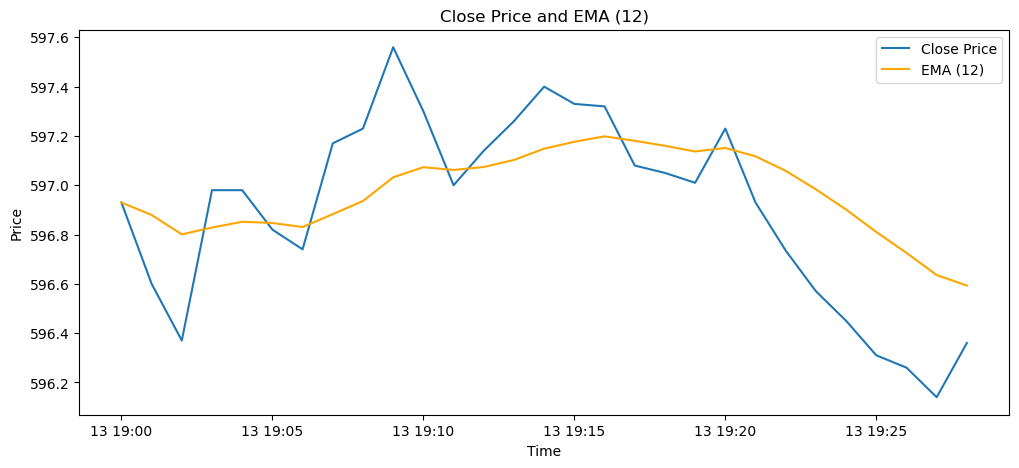

In [115]:
ema_series = calculate_ema(df, period=12)
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['close'], label='Close Price')
sns.lineplot(x=df.index, y=ema_series, label='EMA (12)', color='orange')
plt.title('Close Price and EMA (12)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [117]:
def calculate_rsi(data, period=14) -> pd.Series:
    """Calculates the Relative Strength Index (RSI) for the given data."""
    if data.empty:
        raise ValueError("Input data is empty.")
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [119]:
rsi_series = calculate_rsi(df, period=14)
rsi_series

timestamp
2025-06-13 19:00:00+00:00          NaN
2025-06-13 19:01:00+00:00          NaN
2025-06-13 19:02:00+00:00          NaN
2025-06-13 19:03:00+00:00          NaN
2025-06-13 19:04:00+00:00          NaN
2025-06-13 19:05:00+00:00          NaN
2025-06-13 19:06:00+00:00          NaN
2025-06-13 19:07:00+00:00          NaN
2025-06-13 19:08:00+00:00          NaN
2025-06-13 19:09:00+00:00          NaN
2025-06-13 19:10:00+00:00          NaN
2025-06-13 19:11:00+00:00          NaN
2025-06-13 19:12:00+00:00          NaN
2025-06-13 19:13:00+00:00    55.409836
2025-06-13 19:14:00+00:00    57.366771
2025-06-13 19:15:00+00:00    62.457338
2025-06-13 19:16:00+00:00    67.527675
2025-06-13 19:17:00+00:00    52.136752
2025-06-13 19:18:00+00:00    51.476793
2025-06-13 19:19:00+00:00    54.222222
2025-06-13 19:20:00+00:00    60.251046
2025-06-13 19:21:00+00:00    44.690265
2025-06-13 19:22:00+00:00    39.665971
2025-06-13 19:23:00+00:00    27.802691
2025-06-13 19:24:00+00:00    29.665072
2025-06-13 19:2

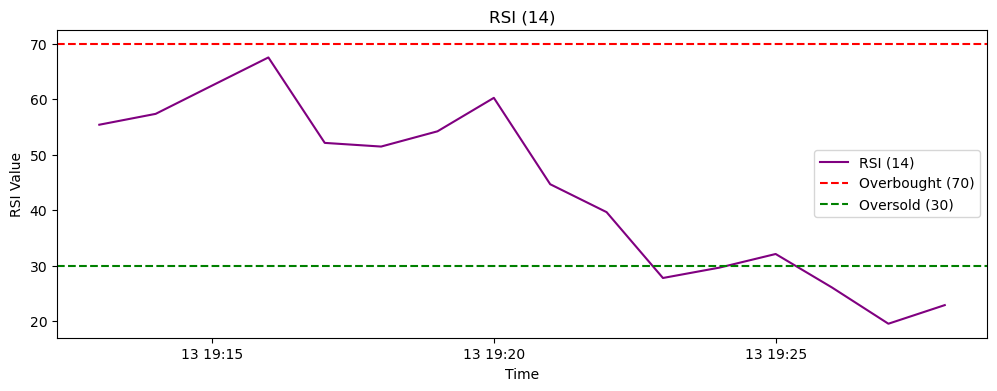

In [120]:
rsi_series = calculate_rsi(df, period=14)
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=rsi_series, label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (14)')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

In [125]:
def average_volume(data, window=20) -> pd.Series:
    """Calculates the average volume over a specified window."""
    if data.empty:
        raise ValueError("Input data is empty.")
    
    avg_vol = data['volume'].rolling(window=window).mean()
    return avg_vol

In [127]:
average_volume_series = average_volume(df)
average_volume_series

timestamp
2025-06-13 19:00:00+00:00        NaN
2025-06-13 19:01:00+00:00        NaN
2025-06-13 19:02:00+00:00        NaN
2025-06-13 19:03:00+00:00        NaN
2025-06-13 19:04:00+00:00        NaN
2025-06-13 19:05:00+00:00        NaN
2025-06-13 19:06:00+00:00        NaN
2025-06-13 19:07:00+00:00        NaN
2025-06-13 19:08:00+00:00        NaN
2025-06-13 19:09:00+00:00        NaN
2025-06-13 19:10:00+00:00        NaN
2025-06-13 19:11:00+00:00        NaN
2025-06-13 19:12:00+00:00        NaN
2025-06-13 19:13:00+00:00        NaN
2025-06-13 19:14:00+00:00        NaN
2025-06-13 19:15:00+00:00        NaN
2025-06-13 19:16:00+00:00        NaN
2025-06-13 19:17:00+00:00        NaN
2025-06-13 19:18:00+00:00        NaN
2025-06-13 19:19:00+00:00    2565.10
2025-06-13 19:20:00+00:00    2667.40
2025-06-13 19:21:00+00:00    2730.20
2025-06-13 19:22:00+00:00    2668.60
2025-06-13 19:23:00+00:00    2793.25
2025-06-13 19:24:00+00:00    3166.25
2025-06-13 19:25:00+00:00    3335.60
2025-06-13 19:26:00+00:00   

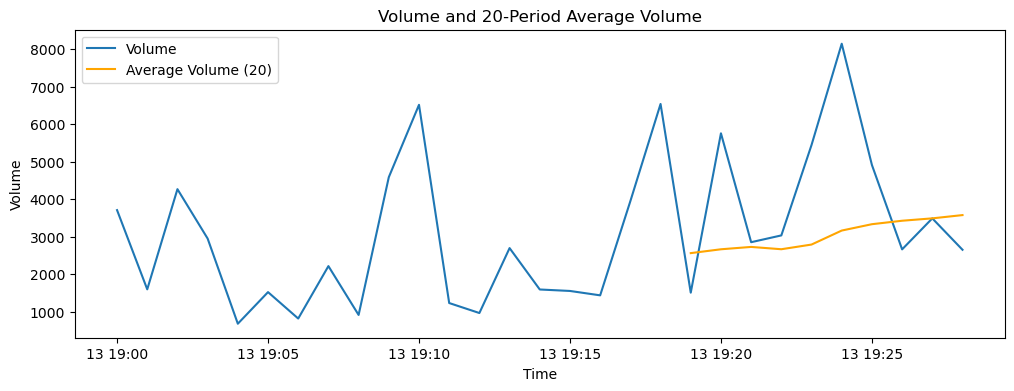

In [128]:
average_volume_series = average_volume(df)
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=df['volume'], label='Volume')
sns.lineplot(x=df.index, y=average_volume_series, label='Average Volume (20)', color='orange')
plt.title('Volume and 20-Period Average Volume')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [129]:
def calculate_slope(series, window=5) -> pd.Series:
    """Calculates the slope of the given series over a specified window."""
    if series.empty:
        raise ValueError("Input series is empty.")
    
    slope = series.diff().rolling(window=window).mean()
    return slope

In [130]:
cal_slope_series = calculate_slope(df['close'])
cal_slope_series

timestamp
2025-06-13 19:00:00+00:00      NaN
2025-06-13 19:01:00+00:00      NaN
2025-06-13 19:02:00+00:00      NaN
2025-06-13 19:03:00+00:00      NaN
2025-06-13 19:04:00+00:00      NaN
2025-06-13 19:05:00+00:00   -0.022
2025-06-13 19:06:00+00:00    0.028
2025-06-13 19:07:00+00:00    0.160
2025-06-13 19:08:00+00:00    0.050
2025-06-13 19:09:00+00:00    0.116
2025-06-13 19:10:00+00:00    0.096
2025-06-13 19:11:00+00:00    0.052
2025-06-13 19:12:00+00:00   -0.006
2025-06-13 19:13:00+00:00    0.006
2025-06-13 19:14:00+00:00   -0.032
2025-06-13 19:15:00+00:00    0.006
2025-06-13 19:16:00+00:00    0.064
2025-06-13 19:17:00+00:00   -0.012
2025-06-13 19:18:00+00:00   -0.042
2025-06-13 19:19:00+00:00   -0.078
2025-06-13 19:20:00+00:00   -0.020
2025-06-13 19:21:00+00:00   -0.078
2025-06-13 19:22:00+00:00   -0.069
2025-06-13 19:23:00+00:00   -0.096
2025-06-13 19:24:00+00:00   -0.112
2025-06-13 19:25:00+00:00   -0.184
2025-06-13 19:26:00+00:00   -0.134
2025-06-13 19:27:00+00:00   -0.119
2025-06-13

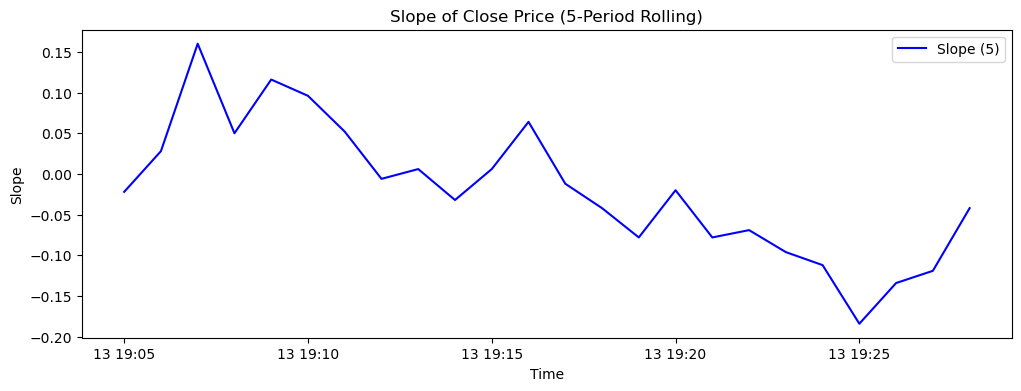

In [131]:
cal_slope_series = calculate_slope(df['close'])
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=cal_slope_series, label='Slope (5)', color='blue')
plt.title('Slope of Close Price (5-Period Rolling)')
plt.xlabel('Time')
plt.ylabel('Slope')
plt.legend()
plt.show()

In [142]:
def check_missing_values(df) -> pd.Series:
    """Checks for missing values in the DataFrame and returns a Series with counts."""
    if df.empty:
        raise ValueError("Input DataFrame is empty.")

    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    print("Missing values in each column:\n", missing_values)
    return missing_values

In [143]:
check_missing_values(df)

Missing values in each column:
 Series([], dtype: int64)


Series([], dtype: int64)

In [144]:
def remove_dividends_splits(df, columns) -> pd.DataFrame:
    """Removes specified columns from the DataFrame."""
    if df.empty:
        raise ValueError("Input DataFrame is empty.")
    try:
        df = df.drop(columns=columns)
    except Exception as e:
        print(f"Data error: {e}")
    print("Remaining columns after removal:\n", df.columns)
    return df

In [145]:
df_removed = remove_dividends_splits(df, ['dividends', 'splits'])
df_removed.columns

Data error: "['dividends', 'splits'] not found in axis"
Remaining columns after removal:
 Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap'],
      dtype='object')


Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap'],
      dtype='object')

In [22]:
def trade():

    position = load_position()
    print(f"position: {position}")

    # --- Modified Cooldown Check ---
    now = datetime.now()
    print(f"now: {now}")

    # Check if last_exit is a non-empty string before attempting to parse
    last_exit_str = position.get('last_exit', '') # Use .get to safely access, default to ''
    print(f"position['last_exit'] string: '{last_exit_str}'")

    if last_exit_str: # Check if the string is not empty
        try:
            last_exit = datetime.fromisoformat(last_exit_str)
            print(f"last_exit (parsed): {last_exit}")

            # Cooldown logic only applies if last_exit was successfully parsed
            formatted_time = last_exit.strftime("%H:%M:%S")
            print(f"formatted_time: {formatted_time}")
            time_from_last_exit = int((now - last_exit).total_seconds())
            print(f"time_from_last_exit: {time_from_last_exit}")
            time_left = COOLDOWN - time_from_last_exit
            print(f"time_left: {time_left}")

            if (time_left < COOLDOWN) and (time_left > 0):
                print(f"Cooldown active until {time_left} seconds from now. Last trade was at {formatted_time}")
                return # Exit the trade function if cooldown is active
        except ValueError:
            # Handle cases where the string is not a valid isoformat
            print(f"Warning: 'last_exit' value '{last_exit_str}' is not a valid ISO format. Assuming no recent exit for cooldown.")
            # Treat as if there was no recent exit (cooldown not active)
            time_left = COOLDOWN + 1 # Ensure time_left is greater than COOLDOWN
    else:
        # If last_exit_str is empty, assume no recent exit (cooldown not active)
        print("'last_exit' is empty. Assuming no recent exit for cooldown.")
        time_left = COOLDOWN + 1 # Ensure time_left is greater than COOLDOWN

    # Rest of your trade logic continues here if cooldown is not active
    trade_count, daily_pnl = check_daily_limits()
    if trade_count >= MAX_TRADES_PER_DAY or daily_pnl <= -DAILY_LOSS_LIMIT:
        print("Daily limit reached.")
        return

    df_1m = get_data(SYMBOL, '1m', 30)
    df_5m = get_data(SYMBOL, '5m', 30)

    if df_1m.empty or df_5m.empty:
        print("Data unavailable.")
        return

    df_1m['ema9'] = calculate_ema(df_1m)
    df_1m['rsi'] = calculate_rsi(df_1m)
    df_1m['avg_volume'] = average_volume(df_1m)

    df_5m['ema50'] = calculate_ema(df_5m, 50)
    df_5m['slope50'] = calculate_slope(df_5m['ema50'])

    last = df_1m.iloc[-1].copy()
    #print("Raw last row values:")
    for k, v in last.items():
        print(f"  {k}: {v}")

    # convert the values in the last row of that DataFrame to a consistent numeric format.
    numerical_columns = df_1m.select_dtypes(include='number').columns.tolist()
    #print(f"Numeric columns: {numerical_columns}")
    for col in numerical_columns:
        try:
            val = last[col]
            if pd.isna(val) or str(val).strip() in ['', 'None', 'nan', 'NaN']:
                raise ValueError(f"Missing or empty value for {col}")
                val = float(val) if isinstance(val, (int, float)) else float(str(val).replace(',', '').strip())
                last[col] = val
        except Exception as e:
            print(f"Data conversion error for '{col}': {e}")

    #last

    slope = float(df_5m['slope50'].iloc[-1])
    print(f"Slope: {slope}")
    side = position.get('side')
    print(f"Side: {side}")
    qty = position.get('qty', 0)
    print(f"Qty: {qty}")
    entry_price = position.get('entry_price', 0)
    print(f"Entry price: {entry_price}")
    buying_power = 100000 #float(api.get_account().cash)
    trade_qty = int((buying_power * POSITION_SIZE_PCT) / last['Close'])
    print(f"Trade qty: {trade_qty}")

    # No position
    if not side:
        print("No position found")
        save_position({'side': 'long', 'entry_price': 100, 'qty': trade_qty, 'high': 200, 'entry_time': now.isoformat()})
        # if last['Close'] > last['Open'] and last['Close'] > last['ema9'] and last['rsi'] < 65 and last['Volume'] > last['avg_volume'] and slope > 0:
        #     price = last['Close'] * 1.001
        #     place_order('buy', trade_qty, price)
        #     save_position({'side': 'long', 'entry_price': price, 'qty': trade_qty, 'high': price, 'entry_time': now.isoformat()})

        # elif last['Close'] < last['Open'] and last['Close'] < last['ema9'] and last['rsi'] > 55 and last['Volume'] > last['avg_volume'] and slope < 0:
        #     price = last['Close'] * 0.999
        #     place_order('sell', trade_qty, price)
        #     save_position({'side': 'short', 'entry_price': price, 'qty': trade_qty, 'low': price, 'entry_time': now.isoformat()})

    # Long Position
    elif side == 'long':
        print("Long Position")
        position['high'] = max(position['high'], last['Close'])
        trail_stop = position['high'] * (1 - TRAILING_STOP_PCT)
        print(f"[LONG] Comparing last['Close'] = {last['Close']} (type: {type(last['Close'])}) to trail_stop = {trail_stop}")
        last_close = float(last['Close'])
        if last_close <= trail_stop or last_close < last['ema9']:
            close_position()
            exit_price = last['Close']
            pnl = (exit_price - entry_price) * qty
            log_trade(position['entry_time'], now.isoformat(), side, entry_price, exit_price, pnl)
            #reset_position()
            save_position({'last_exit': now.isoformat()})

    # Short Position
    elif side == 'short':
        print("Short Position")
        position['low'] = min(position['low'], last['Close'])
        trail_stop = position['low'] * (1 + TRAILING_STOP_PCT)
        print(f"[SHORT] Comparing last['Close'] = {last['Close']} (type: {type(last['Close'])}) to trail_stop = {trail_stop}")
        last_close = float(last['Close'])
        if last_close >= trail_stop or last_close > last['ema9']:
            close_position()
            exit_price = last['Close']
            pnl = (entry_price - exit_price) * qty
            log_trade(position['entry_time'], now.isoformat(), side, entry_price, exit_price, pnl)
            #reset_position()
            save_position({'last_exit': now.isoformat()})


In [52]:
try:
    trade()
except Exception as e:
    print(f"Runtime error: {e}")
#time.sleep(60)

'position.json' already exists.
Successfully loaded position from position.json
position: {'last_exit': '2025-06-12T20:34:21.735676'}
now: 2025-06-12 20:34:33.084023
position['last_exit'] string: '2025-06-12T20:34:21.735676'
last_exit (parsed): 2025-06-12 20:34:21.735676
formatted_time: 20:34:21
time_from_last_exit: 11
time_left: 9
Cooldown active until 9 seconds from now. Last trade was at 20:34:21
